<a href="https://colab.research.google.com/github/kenpurin/Retrosynthesis_TF/blob/main/Transformer_Retrosynthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LANGUAGE TRANSLATION WITH TRANSFORMER

In [4]:
!nvidia-smi

Sat Jun  5 21:29:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#load data and insatall

In [6]:
!git clone https://github.com/kenpurin/Retrosynthesis_TF.git

Cloning into 'Retrosynthesis_TF'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 118 (delta 52), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (118/118), 3.66 MiB | 1.59 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [7]:
!pip3 install rich
!pip3 show torch

     |████████████████████████████████| 204kB 14.8MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
Name: torch
Version: 1.8.1+cu101
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy, typing-extensions
Required-by: torchvision, torchtext, fastai


# Data Processing

In [8]:
import math
import torchtext
import torch
import torch.nn as nn
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
from torchtext.utils import download_from_url, extract_archive
from torch import Tensor
import io
import time
from rich import print
import matplotlib.pyplot as plt


In [9]:
torch.manual_seed(42)
torch.use_deterministic_algorithms(True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.__version__)
print(torch.cuda.is_available())

if device.type == 'cuda':
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
!nvcc --version

1.8.1+cu101

True

Tesla V100-SXM2-16GB

Memory Usage:

Allocated: 0.0 GB

Cached:    0.0 GB

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [10]:
#load data USPTO-50K
train_src_filepaths='Retrosynthesis_TF/USPTO-50K/src/src-train.txt'
train_tgt_filepaths='Retrosynthesis_TF/USPTO-50K/tgt/tgt-train.txt'
val_src_filepaths='Retrosynthesis_TF/USPTO-50K/src/src-val.txt'
val_tgt_filepaths='Retrosynthesis_TF/USPTO-50K/tgt/tgt-val.txt'
test_src_filepaths='Retrosynthesis_TF/USPTO-50K/src/src-test.txt'
test_tgt_filepaths='Retrosynthesis_TF/USPTO-50K/tgt/tgt-test.txt'

In [11]:
#build_vocab
src_filepath='Retrosynthesis_TF/USPTO-50K/src/src.txt'
tgt_filepath='Retrosynthesis_TF/USPTO-50K/tgt/tgt.txt'

In [12]:
#https://pytorch.org/text/stable/data_utils.html use toktok or spacy
tokenizer = get_tokenizer('toktok')

In [13]:
def build_vocab(filepath, tokenizer):
  counter = Counter()
  with io.open(filepath, encoding="utf8") as f:
    for string_ in f:
      counter.update(tokenizer(string_))
  return Vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])
src_vocab = build_vocab(src_filepath,tokenizer)
tgt_vocab = build_vocab(tgt_filepath,tokenizer)

In [14]:
def data_process(filepaths1,filepaths2):
  raw_src_iter = iter(io.open(filepaths1, encoding="utf8"))
  raw_tgt_iter = iter(io.open(filepaths2, encoding="utf8"))
  data = []
  for (raw_src, raw_tgt) in zip(raw_src_iter, raw_tgt_iter):
    src_tensor_ = torch.tensor([src_vocab[token] for token in tokenizer(raw_src.rstrip("\n"))],
                            dtype=torch.long)
    tgt_tensor_ = torch.tensor([tgt_vocab[token] for token in tokenizer(raw_tgt.rstrip("\n"))],
                            dtype=torch.long)
    data.append((src_tensor_, tgt_tensor_))
  return data

In [15]:
train_data = data_process(train_src_filepaths,train_tgt_filepaths)
val_data = data_process(val_src_filepaths,val_tgt_filepaths)
test_data = data_process(test_src_filepaths,test_tgt_filepaths)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#default BATCH_SIZE =128
BATCH_SIZE = 32
PAD_IDX = src_vocab['<pad>']
BOS_IDX = src_vocab['<bos>']
EOS_IDX = src_vocab['<eos>']

# DataLoader

In [17]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def generate_batch(data_batch):
  src_batch, tgt_batch = [], []
  for (src_item, tgt_item) in data_batch:
    src_batch.append(torch.cat([torch.tensor([BOS_IDX]), src_item, torch.tensor([EOS_IDX])], dim=0))
    tgt_batch.append(torch.cat([torch.tensor([BOS_IDX]), tgt_item, torch.tensor([EOS_IDX])], dim=0))
  src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
  tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
  return src_batch, tgt_batch

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE,
                       shuffle=True, collate_fn=generate_batch)

#Transformer

In [18]:
#https://pytorch.org/docs/master/nn.html?highlight=multiheadattention#torch.nn.MultiheadAttention
from torch.nn import (TransformerEncoder, TransformerDecoder,
                      TransformerEncoderLayer, TransformerDecoderLayer)


class Seq2SeqTransformer(nn.Module):
    def __init__(self, num_encoder_layers: int, num_decoder_layers: int,
                 emb_size: int, src_vocab_size: int, tgt_vocab_size: int,
                 dim_feedforward:int = 512, dropout:float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        #TransformerEncoderLayer is made up of self-attn and feedforward network.
        encoder_layer = TransformerEncoderLayer(d_model=emb_size, nhead=NHEAD,
                                                dim_feedforward=dim_feedforward)
        #TransformerEncoder is a stack of N encoder layers
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        #	TransformerDecoderLayer is made up of self-attn, multi-head-attn and feedforward network.
        decoder_layer = TransformerDecoderLayer(d_model=emb_size, nhead=NHEAD,
                                                dim_feedforward=dim_feedforward)
        #TransformerDecoder is a stack of N decoder layers
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    def forward(self, src: Tensor, trg: Tensor, src_mask: Tensor,
                tgt_mask: Tensor, src_padding_mask: Tensor,
                tgt_padding_mask: Tensor, memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        memory = self.transformer_encoder(src_emb, src_mask, src_padding_mask)
        outs = self.transformer_decoder(tgt_emb, memory, tgt_mask, None,
                                        tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer_encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer_decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [19]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding +
                            self.pos_embedding[:token_embedding.size(0),:])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [20]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt):
  src_seq_len = src.shape[0]
  tgt_seq_len = tgt.shape[0]

  tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
  src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).type(torch.bool)

  src_padding_mask = (src == PAD_IDX).transpose(0, 1)
  tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
  return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [21]:
# Training hyperparameters
#default BATCH_SIZE = 128 NUM_ENCODER_LAYERS = 3 NUM_DECODER_LAYERS = 3

SRC_VOCAB_SIZE = len(src_vocab)
TGT_VOCAB_SIZE = len(tgt_vocab)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 32
NUM_ENCODER_LAYERS = 4
NUM_DECODER_LAYERS = 4
NUM_EPOCHS = 100

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS,
                                 EMB_SIZE, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE,
                                 FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
#model 
transformer = transformer.to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
#default optimizer  lr=0.0001 ,betas=(0.9, 0.98) ,eps=1e-9
optimizer = torch.optim.Adam(
    transformer.parameters(), lr=2, betas=(0.9, 0.998), eps=1e-9
)

In [22]:
#show model
print(transformer)

Seq2SeqTransformer(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (2): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (3): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (transformer_decoder): TransformerDecoder(
    (layers): ModuleList(
      (0): TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
        (dropout3): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias

#Save checkpoint

In [23]:
load_model = True
save_model = True

In [24]:
def save_checkpoint(state, filename):
    #filename="my_checkpoint_"+str(epoch)+".pth"
    print("=> Saving checkpoint")
    torch.save(state, filename)

#Load checkpoint

In [ ]:
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [ ]:
if load_model:
    load_checkpoint(torch.load("/content/gdrive/MyDrive/code retrosynthesis/checkpoint/my_checkpoint_200.pth"), transformer, optimizer)



=> Loading checkpoint

# Train and Evaluate function

In [25]:
def train_epoch(model, train_iter, optimizer):
  model.train()
  losses = 0
  for idx, (src, tgt) in enumerate(train_iter):
      src = src.to(device)
      tgt = tgt.to(device)

      tgt_input = tgt[:-1, :]

      src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

      logits = model(src, tgt_input, src_mask, tgt_mask,
                                src_padding_mask, tgt_padding_mask, src_padding_mask)

      optimizer.zero_grad()

      tgt_out = tgt[1:,:]
      loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
      loss.backward()

      optimizer.step()
      losses += loss.item()
  return losses / len(train_iter)


def evaluate(model, val_iter):
  model.eval()
  losses = 0
  for idx, (src, tgt) in (enumerate(valid_iter)):
    src = src.to(device)
    tgt = tgt.to(device)

    tgt_input = tgt[:-1, :]

    src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

    logits = model(src, tgt_input, src_mask, tgt_mask,
                              src_padding_mask, tgt_padding_mask, src_padding_mask)
    tgt_out = tgt[1:,:]
    loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
    losses += loss.item()
  return losses / len(val_iter)

#Train model

In [ ]:
train_loss_ex = []
val_loss_ex = []
epoch_ex=[]
for epoch in range(1, NUM_EPOCHS+1):
  start_time = time.time()
  train_loss = train_epoch(transformer, train_iter, optimizer)
  end_time = time.time()
  val_loss = evaluate(transformer, valid_iter)
  #Save the general checkpoint
  if epoch%100==0:
    filename="my_checkpoint_"+str(epoch)+".pth"
    print("true")
    checkpoint = {"state_dict": transformer.state_dict(),"optimizer": optimizer.state_dict(),}
    save_checkpoint(checkpoint,filename)

  print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "
          f"Epoch time = {(end_time - start_time):.3f}s"))
  #plot
  train_loss_ex.append(train_loss)
  epoch_ex.append(epoch)
  val_loss_ex.append(val_loss)
  
print("Done!")

Epoch: 1, Train loss: 0.023, Val loss: 0.134, Epoch time = 94.601s

Done!

#Plot graph

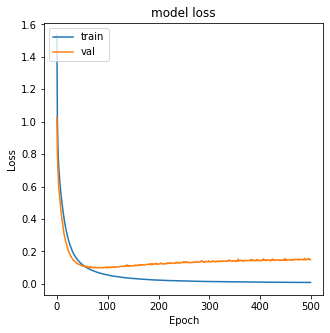

In [ ]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
import numpy as np
#https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
plt.figure(figsize=(5,5))
plt.plot(train_loss_ex)
plt.plot(val_loss_ex)
#plt.yticks(np.arange(0.2, 1.5, step=0.1))
#plt.xticks(np.arange(1, 15, step=1))
plt.title("model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#total_data_loss = pd.Series(epoch_ex,train_loss_ex,val_loss_ex)
total_train_loss = pd.Series(train_loss_ex)
total_val_loss = pd.Series(val_loss_ex)
total_train_loss=pd.DataFrame(total_train_loss, columns=["train loss"])
total_val_loss =pd.DataFrame(total_val_loss, columns=["val loss"])
total_data_loss=pd.concat([total_train_loss,total_val_loss], axis=1)
total_train_loss
total_data_loss.to_csv(r'total_loss.csv',  index=None)

# Save model

In [ ]:
#https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html

In [ ]:
save_name="model_tranformer_epochs_"+str(NUM_EPOCHS)+".pth"
torch.save(transformer,save_name)

In [ ]:
from google.colab import files
files.download(save_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

save file .pt

In [ ]:
save_name_pt="model_tranformer_epochs_"+str(NUM_EPOCHS)+".pt"
torch.save(transformer,save_name_pt)

In [ ]:
files.download("/content/my_checkpoint_300.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Load model

In [26]:
model = torch.load('/content/gdrive/MyDrive/code retrosynthesis/model/model_tranformer_epochs_500.pth')

#Translation

In [27]:
import pandas as pd
import numpy as np

In [28]:
df_src=pd.read_csv(src_filepath,names=["input"])
df_tgt=pd.read_csv(tgt_filepath,names=["target"])
df = pd.concat([df_src,df_tgt], axis=1)
df

,input,target
0,<RX_1> O = C 1 C C [ C @ H ] ( C N 2 C C N ( C...,C S ( = O ) ( = O ) O C [ C @ H ] 1 C C C ( = ...
1,<RX_6> N c 1 n c 2 [ n H ] c ( C C C c 3 c s c...,C O C ( = O ) c 1 c c ( C C C c 2 c c 3 c ( = ...
2,<RX_9> C C 1 ( C ) O B ( c 2 c c c c ( N c 3 n...,C C 1 ( C ) O B ( B 2 O C ( C ) ( C ) C ( C ) ...
3,<RX_6> C C ( C ) ( C ) O C ( = O ) N C C ( = O...,C C ( C ) ( C ) O C ( = O ) N C C ( = O ) C C ...
4,<RX_1> F c 1 c c 2 c ( N C 3 C C C C C C 3 ) n...,F c 1 c c 2 c ( C l ) n c n c 2 c n 1 . N C 1 ...
...,...,...
50032,<RX_1> C C ( C ) ( C ) O C ( = O ) N 1 C C c 2...,C C ( C ) ( C ) O C ( = O ) N 1 C C c 2 c c c ...
50033,<RX_2> C C ( = O ) O C C N C ( = O ) O C ( C )...,C C ( = O ) C l . C C ( C ) ( C ) O C ( = O ) ...
50034,<RX_3> C c 1 c c c ( - c 2 c c n c c 2 ) c c 1...,C c 1 c c c ( B r ) c c 1 C = O . O B ( O ) c ...
50035,<RX_1> C C ( C ) ( C ) O C 1 C [ C @ @ H ] 2 C...,C C ( C ) ( C ) O . O = C C 1 = C [ C @ H ] 2 ...


In [26]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(device)
    src_mask = src_mask.to(device)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        memory = memory.to(device)
        memory_mask = torch.zeros(ys.shape[0], memory.shape[0]).to(device).type(torch.bool)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                                    .type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        
        if next_word == EOS_IDX:
          break
    return ys


def translate(model, src, src_vocab, tgt_vocab, src_tokenizer):
  model.eval()
  tokens = [BOS_IDX] + [src_vocab.stoi[tok] for tok in src_tokenizer(src)]+ [EOS_IDX]
  num_tokens = len(tokens)
  src = (torch.LongTensor(tokens).reshape(num_tokens, 1) )
  src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
  tgt_tokens = greedy_decode(model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
 
  print("Product:"+ " "+df.input[i])
  print("Reaction Real:"+" "+df.target[i])
  return print("prediction:"+" ".join([tgt_vocab.itos[tok] for tok in tgt_tokens]).replace("<bos>", "").replace("<eos>", ""))
  #return " ".join([tgt_vocab.itos[tok] for tok in tgt_tokens]).replace("<bos>", "").replace("<eos>", "")

In [28]:
i=50034
translate(transformer, df.input[i], src_vocab, tgt_vocab, tokenizer)

Product: <RX_3> C c 1 c c c ( - c 2 c c n c c 2 ) c c 1 C = O

Reaction Real: C c 1 c c c ( B r ) c c 1 C = O . O B ( O ) c 1 c c n c c 1

prediction: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 
<unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 
<unk> <unk>

In [ ]:
for i in range(50000,50010):
  translate(transformer, df.input[i], src_vocab, tgt_vocab, tokenizer)
  print("    ")

#beam search 

In [29]:
import pandas as pd
import numpy as np
df_src=pd.read_csv(src_filepath,names=["input"])
df_tgt=pd.read_csv(tgt_filepath,names=["target"])
df = pd.concat([df_src,df_tgt], axis=1)

In [30]:
df_test=pd.read_csv("/content/Retrosynthesis_TF/USPTO-50K/src/src-test.txt",names=["input"])
df_test

,input
0,<RX_1> C O C ( = O ) C C C ( = O ) c 1 c c c (...
1,<RX_4> C O C ( = O ) c 1 c c c c ( - c 2 n c 3...
2,<RX_2> C O N ( C ) C ( = O ) C 1 C C C ( N C (...
3,<RX_1> O = [ N + ] ( [ O - ] ) c 1 c c c ( C l...
4,<RX_9> N C C 1 = C C [ C @ @ H ] ( c 2 c c c (...
...,...
4999,<RX_1> C c 1 c c ( [ N + ] ( = O ) [ O - ] ) c...
5000,<RX_6> C O C ( = O ) c 1 [ n H ] c 2 c c ( C l...
5001,<RX_7> C O c 1 c c ( C ( F ) ( F ) F ) c c ( S...
5002,<RX_10> C c 1 n n ( C C ( C ) C O ) c ( - c 2 ...


In [31]:
def beam_decode(model, src, src_mask, max_len, start_symbol,k):
    src = src.to(device)
    src_mask = src_mask.to(device)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        memory = memory.to(device)
        memory_mask = torch.zeros(ys.shape[0], memory.shape[0]).to(device).type(torch.bool)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                                    .type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        #note topK
        prb,next_topk=torch.topk(prob,k,dim=1)
        print(torch.topk(prob,k,dim=1))
        #print(prb[0][0])
        #print(next_topk[0][0])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_topk[0][0])], dim=0)
        
        if next_topk[0][0]== EOS_IDX:
          break
    return ys


def translate(model, src, src_vocab, tgt_vocab, src_tokenizer):
  model.eval()
  tokens = [BOS_IDX] + [src_vocab.stoi[tok] for tok in src_tokenizer(src)]+ [EOS_IDX]
  num_tokens = len(tokens)
  src = (torch.LongTensor(tokens).reshape(num_tokens, 1) )
  src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
  tgt_tokens = beam_decode(model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX,k=10).flatten()
  print(len(tgt_tokens))
  print("Product:"+ " "+df.input[i])
  print("Reaction Real:"+" "+df.target[i])
  return print("prediction:"+" ".join([tgt_vocab.itos[tok] for tok in tgt_tokens]).replace("<bos>", "").replace("<eos>", ""))
  #return " ".join([tgt_vocab.itos[tok] for tok in tgt_tokens]).replace("<bos>", "").replace("<eos>", "")

In [32]:
i=2
translate(model, df_test.input[i], src_vocab, tgt_vocab, tokenizer)

torch.return_types.topk(
values=tensor([[25.1870,  5.6188,  3.6242,  2.2338,  0.8583,  0.4720,  0.4251,  0.3651,
         -0.9776, -1.7779]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[ 5, 12,  9,  6, 23, 32, 11, 20, 15,  7]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[21.1440,  8.4856,  6.4649,  3.2875,  2.7114,  1.3354, -1.3253, -1.4336,
         -2.1773, -2.3646]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[ 5, 12,  9, 32, 11,  6, 13, 20, 23, 25]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[24.4416,  6.3850,  4.4043,  4.1061,  2.8873,  0.7177,  0.3374,  0.1209,
          0.0977, -0.0264]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[ 6,  5,  8,  9, 21,  4,  7, 13, 20, 12]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[22.0828,  3.7668,  3.1564,  2.6610,  2.4861,  1.9270,  0.2724, -0.6049,
         -1.6675, -2.1063]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[ 5, 11,  6, 12, 17,  4,  7,  9, 23, 32]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[28.4396,  6.6345,  6.6053,  6.1112,  5.7402,  3.1059,  2.1336,  1.5851,
          0.8734, -0.6190]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[ 7,  5, 14,  6, 19,  3, 12, 21,  9,  4]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[23.3963,  4.0178,  3.8988,  3.7337,  2.7941,  1.0948,  0.2241, -0.1674,
         -0.2706, -1.1247]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[ 6,  4,  9,  5,  7, 12, 24,  8, 15, 10]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[2.3713e+01, 3.5904e+00, 2.3726e+00, 1.8688e+00, 1.0508e+00, 8.6047e-01,
         5.0597e-01, 3.0876e-01, 2.2213e-01, 1.5568e-02]], device='cuda:0',
       grad_fn=<TopkBackward>),
indices=tensor([[ 5, 12,  9, 17,  7, 23, 14,  6, 32, 11]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[27.8649,  6.5191,  6.4270,  4.9387,  2.2865,  1.8261,  1.6311,  1.4132,
          0.9677,  0.6981]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[ 7, 14,  5,  9, 32, 12,  3,  6, 17, 19]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[27.3617,  6.0055,  5.3672,  4.0880,  3.9482,  2.1461,  1.0059,  0.7118,
          0.7003,  0.4307]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[ 9, 24,  6,  5, 15,  4, 31, 23, 30,  7]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[23.3179,  7.3005,  4.2181,  3.4390,  1.6477,  0.6121, -0.6399, -0.7368,
         -1.1035, -1.4220]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[ 5,  9, 24, 14,  6, 32, 15,  4, 12, 13]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[27.1433,  8.3723,  7.1003,  7.0815,  5.0796,  4.8594,  3.3891,  1.4026,
          0.4142, -0.5082]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[ 6, 20,  5, 16,  8, 11, 21, 12,  7, 14]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[31.4904, 11.5826, 11.0984,  6.1664,  3.5548,  2.5727,  1.7849,  1.5916,
         -0.2837, -0.4664]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[11, 12,  5,  9, 20, 16,  4, 17,  6,  7]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[29.1836, 13.8733,  4.3044,  3.0795,  2.8205,  2.5958,  2.4306,  1.4788,
          0.2779, -0.0894]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[ 9, 12,  5,  7, 24, 13, 16, 23, 21, 20]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[32.5661, 17.2380,  9.1127,  8.0863,  8.0764,  5.7690,  3.3985,  3.1574,
          2.8319,  2.1943]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[ 7, 14,  3, 12, 16,  9, 32, 36, 45, 21]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[28.6090, 10.5001,  4.8216,  2.6770,  1.8388,  1.6875,  1.2844,  1.1975,
          1.0520,  0.3365]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[12,  5, 13,  9, 23, 32, 15,  6, 11, 30]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[20.1841,  7.6307,  4.4969,  3.6475,  1.3344,  1.0856,  0.7279, -0.0204,
         -0.8642, -1.5306]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[ 5, 15, 12, 24,  8,  6, 11,  9, 13,  4]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[24.9741,  8.7507,  8.2663,  7.2468,  4.0052,  3.7466,  1.9037,  1.4089,
          1.3912, -0.7205]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[ 8, 10,  6,  5,  4, 18, 26, 15, 20, 33]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[19.9258,  9.9571,  8.1299,  3.4398,  1.4066,  0.2289, -0.6533, -1.0648,
         -1.1345, -1.9865]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[ 5,  6, 10, 11,  8, 24, 28, 14, 18,  7]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[21.2101,  3.6976,  0.9597,  0.8683,  0.7618, -0.4817, -1.1962, -1.2045,
         -1.2073, -1.2612]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[ 5,  6,  7,  4,  8, 24, 10, 28, 20, 17]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[17.8805,  8.4562,  2.5045,  2.1379,  1.8803,  1.0560,  0.0937, -0.1869,
         -0.2619, -1.1625]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[ 5, 15,  8,  6, 24,  4, 13,  9, 12,  7]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[22.9327,  8.7975,  8.1039,  5.8785,  2.2433, -0.4625, -1.1764, -1.8378,
         -2.3193, -2.5419]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[ 6,  5,  8, 10, 18, 28,  7, 26, 13,  4]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[19.2431,  3.4248,  3.0367,  1.3296,  0.8697, -0.1401, -0.6511, -0.9719,
         -1.6756, -1.8137]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[ 5,  6, 24, 15,  9,  8, 10,  4, 32, 13]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[21.7831,  9.2309,  7.6621,  7.4101,  2.9127,  1.9990,  1.3737,  1.0058,
          0.4972, -1.0185]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[ 6, 10,  5,  8, 28, 11,  9, 19, 18, 20]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[30.6765,  8.3601,  7.9163,  6.7774,  5.5527, -0.2545, -0.3094, -0.9212,
         -1.6132, -1.7589]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[11,  5,  9, 12,  4, 13,  6, 17,  7, 23]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[28.5436,  8.8331,  4.5218,  3.7575,  3.3026,  1.0891,  0.1994, -0.2918,
         -0.3197, -0.4066]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[ 9,  5, 24, 12, 13, 11,  4,  6, 23, 17]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[33.5271,  9.7277,  8.8633,  6.9520,  2.3398,  2.1066,  1.6530,  1.4551,
          1.1714,  0.6622]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[ 7, 14,  9, 16,  3, 11, 13, 19, 27, 21]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[28.9189,  9.7688,  7.8888,  7.6489,  4.9564,  4.2422,  3.7023,  3.3908,
          0.5460,  0.3429]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[ 9, 15,  5, 17, 11, 23, 21, 24,  4,  7]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[28.5308, 14.7771, 10.2256,  8.6547,  5.9899,  4.9339,  4.3202,  2.7438,
          1.8615,  0.4196]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[ 7, 14, 24,  3,  9, 11,  5, 19, 12, 21]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[22.1870,  7.2569,  5.5692,  3.5250, -0.6419, -1.2388, -1.5469, -1.8634,
         -1.8655, -1.9618]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[ 5,  6, 11, 24,  4,  9, 17, 15,  7, 12]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[19.0908,  3.9796,  2.7142,  1.2898,  0.4961,  0.4132, -0.2452, -1.7498,
         -1.9600, -2.2878]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[ 5,  6,  8, 24,  4,  7, 11, 15, 17, 10]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[27.9735,  5.9162,  4.0888,  3.6364,  2.3844,  1.3836,  0.7102,  0.1929,
          0.1490,  0.0657]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[ 8,  5, 12, 18, 43, 33, 21,  6,  4, 10]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[30.2739, 19.3241,  2.8984,  2.4171,  1.1127,  0.7754,  0.1625,  0.1352,
         -0.1823, -0.5884]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[14,  3, 12,  5, 11,  6, 32,  4, 13, 40]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[25.1034,  5.1021,  4.6349,  1.5697,  1.1213,  0.7573,  0.1758, -1.1051,
         -1.5349, -2.2082]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[ 5,  9, 12, 23,  6, 11, 15, 20, 14,  4]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[26.3930, 13.7767, 13.6124,  5.0088,  4.0966,  0.7653, -1.2600, -1.5079,
         -2.8881, -3.1631]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[12,  5,  9, 11, 15, 31,  6, 23, 21, 17]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[25.3311,  7.2417,  6.9853,  2.8530,  1.9086,  0.4966, -0.0397, -0.5060,
         -0.7716, -1.9635]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[ 9,  5, 21,  3, 17, 12, 11, 15, 24, 30]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[23.2131,  5.5967,  0.8120, -0.3657, -0.5855, -0.7579, -0.8702, -0.9244,
         -1.0065, -1.2931]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[ 5,  3,  6, 10,  9,  4, 13, 15,  8, 26]], device='cuda:0'))

torch.return_types.topk(
values=tensor([[34.1152, 13.8401,  7.6149,  7.0442,  6.7545,  1.2067,  1.0494,  0.3904,
          0.2443, -0.8670]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[ 3, 14,  5,  7, 19,  8,  4, 13, 17, 11]], device='cuda:0'))

38

Product: <RX_9> C C 1 ( C ) O B ( c 2 c c c c ( N c 3 n c c c ( C ( F ) ( F ) F ) n 3 ) c 2 )
O C 1 ( C ) C

Reaction Real: C C 1 ( C ) O B ( B 2 O C ( C ) ( C ) C ( C ) ( C ) O 2 ) O C 1 ( C ) C . F C 
( F ) ( F ) c 1 c c n c ( N c 2 c c c c ( B r ) c 2 ) n 1

prediction: C C ( C ) ( C ) O C ( = O ) N C 1 C C C ( C ( = O ) O ) C C 1 . C N O C

In [33]:
print(len("C O C ( = O ) c 1 c c c c ( C ( = O ) O ) c 1 . N c 1 c c c n c 1 N".replace(" ", "")))

34

#TEST

In [56]:
df_test=pd.read_csv("/content/Retrosynthesis_TF/USPTO-50K/src/src-test.txt",names=["input"])
df_test

,input
0,<RX_1> C O C ( = O ) C C C ( = O ) c 1 c c c (...
1,<RX_4> C O C ( = O ) c 1 c c c c ( - c 2 n c 3...
2,<RX_2> C O N ( C ) C ( = O ) C 1 C C C ( N C (...
3,<RX_1> O = [ N + ] ( [ O - ] ) c 1 c c c ( C l...
4,<RX_9> N C C 1 = C C [ C @ @ H ] ( c 2 c c c (...
...,...
4999,<RX_1> C c 1 c c ( [ N + ] ( = O ) [ O - ] ) c...
5000,<RX_6> C O C ( = O ) c 1 [ n H ] c 2 c c ( C l...
5001,<RX_7> C O c 1 c c ( C ( F ) ( F ) F ) c c ( S...
5002,<RX_10> C c 1 n n ( C C ( C ) C O ) c ( - c 2 ...


In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(device)
    src_mask = src_mask.to(device)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        memory = memory.to(device)
        memory_mask = torch.zeros(ys.shape[0], memory.shape[0]).to(device).type(torch.bool)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                                    .type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        
        if next_word == EOS_IDX:
          break
    return ys


def translate(model, src, src_vocab, tgt_vocab, src_tokenizer):
  model.eval()
  tokens = [BOS_IDX] + [src_vocab.stoi[tok] for tok in src_tokenizer(src)]+ [EOS_IDX]
  num_tokens = len(tokens)
  src = (torch.LongTensor(tokens).reshape(num_tokens, 1) )
  src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
  tgt_tokens = greedy_decode(model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
 
  #print("Product:"+ " "+df.input[i])
  #print("Reaction Real:"+" "+df.target[i])
  #return print("prediction:"+" ".join([tgt_vocab.itos[tok] for tok in tgt_tokens]).replace("<bos>", "").replace("<eos>", ""))
  return " ".join([tgt_vocab.itos[tok] for tok in tgt_tokens]).replace("<bos>", "").replace("<eos>", "")

In [ ]:
len(df_test.input)


5004

In [ ]:
#500 epoch
model = torch.load('/content/gdrive/MyDrive/code retrosynthesis/model/model_tranformer_epochs_500.pth')

In [ ]:
i=50034
translate(model, df.input[i], src_vocab, tgt_vocab, tokenizer)

' C c 1 c c c ( B r ) c c 1 C = O . O B ( O ) c 1 c c n c c 1'

In [ ]:
a=0
src_input=[]
for i in range(len(df_test)):
  #model
  translate_src=translate(model, df_test.input[i], src_vocab, tgt_vocab, tokenizer)
  #for n in range(1,11):
    #translate_src=translate(transformer, df.input[i], src_vocab, tgt_vocab, tokenizer)
  src_input.append(translate_src)
  a=a+1
print(a)         

5004

In [ ]:
df_test_prediction = pd.Series(src_input)
df_test_prediction

0        C 1 = C O C C C 1 . C O C ( = O ) C C C ( = O...
1        C O C ( = O ) c 1 c c c c ( C ( = O ) O ) c 1...
2        C C ( C ) ( C ) O C ( = O ) N C 1 C C C ( C (...
3        N c 1 c c c ( O ) c c 1 . O = [ N + ] ( [ O -...
4        [ N - ] = [ N + ] = N C C 1 = C C [ C @ @ H ]...
                              ...                        
4999     C c 1 c c ( [ N + ] ( = O ) [ O - ] ) c c c 1...
5000     C O C ( = O ) C C 1 C C c 2 c ( C l ) c c 3 [...
5001     C O c 1 c c ( C ( F ) ( F ) F ) c c ( S C ) c...
5002     C C ( C ) C n 1 n c ( C ) c ( B r ) c 1 - c 1...
5003     C O C ( = O ) c 1 c c ( S C c 2 c c c ( O C )...
Length: 5004, dtype: object

In [ ]:
df_test_prediction= pd.DataFrame(df_test_prediction, columns=["prediction"])
df_test_prediction

,prediction
0,C 1 = C O C C C 1 . C O C ( = O ) C C C ( = O...
1,C O C ( = O ) c 1 c c c c ( C ( = O ) O ) c 1...
2,C C ( C ) ( C ) O C ( = O ) N C 1 C C C ( C (...
3,N c 1 c c c ( O ) c c 1 . O = [ N + ] ( [ O -...
4,[ N - ] = [ N + ] = N C C 1 = C C [ C @ @ H ]...
...,...
4999,C c 1 c c ( [ N + ] ( = O ) [ O - ] ) c c c 1...
5000,C O C ( = O ) C C 1 C C c 2 c ( C l ) c c 3 [...
5001,C O c 1 c c ( C ( F ) ( F ) F ) c c ( S C ) c...
5002,C C ( C ) C n 1 n c ( C ) c ( B r ) c 1 - c 1...


In [ ]:
#save df to .txt

In [ ]:
#https://stackoverflow.com/questions/31247198/python-pandas-write-content-of-dataframe-into-text-file
df_test_prediction.to_csv(r'predictions_top2.txt', header=None, index=None)
#files.download('predictions_top1.txt')